In [ ]:
! uv pip install agentics-py
! uv pip install 'crewai[tools]'

import os
import sys
from getpass import getpass

import numpy as np
from math import log, exp, sqrt
from scipy import stats

from dotenv import find_dotenv, load_dotenv

import matplotlib.pyplot as plt

CURRENT_PATH = ""

os.environ["GEMINI_API_KEY"] = 

def print_newlines(string, every=128):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

Using Python 3.12.11 environment at: /Users/bzqzhu/Desktop/agentics/.venv
Audited 1 package in 183ms
Using Python 3.12.11 environment at: /Users/bzqzhu/Desktop/agentics/.venv
Audited 1 package in 18ms


In [8]:
def get_liquidity_level(pL,pU,dX,dY):

    a = np.sqrt(pL/pU)-1
    b = dX*np.sqrt(pL)+dY/np.sqrt(pU)
    c = dX*dY
    num = -b-np.sqrt(b**2-4*a*c)
    dnm = 2*a
    
    return (num/dnm)**2

def getLiquidityLevel(P,PL,PU,p0,p1,B):
    x0 = 1
    y0 = ((np.sqrt(P)-np.sqrt(PL))/(np.sqrt(PU)-np.sqrt(P)))*np.sqrt(P*PU)
    x = (B/(p0+p1*y0))*x0
    y = (B/(p0+p1*y0))*y0
    tL = (-np.log(PL)+12*np.log(10))/np.log(1.0001)
    tU = (-np.log(PU)+12*np.log(10))/np.log(1.0001)
    return np.sqrt(get_liquidity_level(np.power(1.0001,min(tL,tU)),np.power(1.0001,max(tL,tU)),y*1e6,x*1e18))

def getTokenReserves(L,P,PL,PU):
    if P < PL:
        x = L*(np.sqrt(PU)-np.sqrt(PL))/np.sqrt(PL*PU)
        y = 0
    elif (PL <= P) and (P <= PU):
        x = L*(np.sqrt(PU)-np.sqrt(P))/np.sqrt(P*PU)
        y = L*(np.sqrt(P)-np.sqrt(PL))
    else:
        x = 0
        y = L*(np.sqrt(PU)-np.sqrt(PL))
    return x/1e12, y/1e12

def evaluate(decision_df,B):

    input_df = decision_df.copy()

    L_list = []
    burn_list = []
    mint_list = []
    gas_list = []
    fee_list = []

    position_created = 0
    for i in range(len(input_df)):

        curr_row = input_df.iloc[i]

        if np.isnan(curr_row.price_lower) == 0:
            position_created = 1
        
        if position_created:

            prev_row = input_df.iloc[i-1]

            if np.isnan(prev_row.price_lower) == 1:
                L_curr = getLiquidityLevel(prev_row.price_ratio,curr_row.price_lower,curr_row.price_upper,prev_row.price_0,prev_row.price_1,B)
                x_curr, y_curr = getTokenReserves(L_curr,prev_row.price_ratio,curr_row.price_lower,curr_row.price_upper)
                mint = prev_row.price_0*x_curr+prev_row.price_1*y_curr
                L_list.append(L_curr)
                burn_list.append(0)
                mint_list.append(mint)
                gas_list.append(prev_row.gas_usd)
                if (curr_row.price_lower <= curr_row.price_ratio) and (curr_row.price_ratio <= curr_row.price_upper):
                    fee_list.append((L_curr/curr_row.liquidity)*curr_row.fee_usd)
                else:
                    fee_list.append(0)

            else:

                if i == len(input_df)-1:
                    L_curr = L_list[-1]
                    x_curr, y_curr = getTokenReserves(L_curr,curr_row.price_ratio,curr_row.price_lower,curr_row.price_upper)
                    burn = curr_row.price_0*x_curr+curr_row.price_1*y_curr
                    L_list.append(L_curr)
                    burn_list.append(burn)
                    mint_list.append(0)
                    gas_list.append(0)
                    if (curr_row.price_lower <= curr_row.price_ratio) and (curr_row.price_ratio <= curr_row.price_upper):
                        fee_list.append((L_curr/curr_row.liquidity)*curr_row.fee_usd)
                    else:
                        fee_list.append(0)

                else:
                
                    if (curr_row.price_lower == prev_row.price_lower) and (curr_row.price_upper == prev_row.price_upper):
                        L_curr = L_list[-1]
                        L_list.append(L_curr)
                        burn_list.append(0)
                        mint_list.append(0)
                        gas_list.append(0)
                        if (curr_row.price_lower <= curr_row.price_ratio) and (curr_row.price_ratio <= curr_row.price_upper):
                            fee_list.append((L_curr/curr_row.liquidity)*curr_row.fee_usd)
                        else:
                            fee_list.append(0)
                    
                    else:
                        L_prev = L_list[-1]
                        x_prev, y_prev = getTokenReserves(L_prev,prev_row.price_ratio,prev_row.price_lower,prev_row.price_upper)
                        B = prev_row.price_0*x_prev+prev_row.price_1*y_prev
                        L_curr = getLiquidityLevel(prev_row.price_ratio,curr_row.price_lower,curr_row.price_upper,prev_row.price_0,prev_row.price_1,B)
                        x_curr, y_curr = getTokenReserves(L_curr,prev_row.price_ratio,curr_row.price_lower,curr_row.price_upper)
                        burn = prev_row.price_0*x_prev+prev_row.price_1*y_prev
                        mint = prev_row.price_0*x_curr+prev_row.price_1*y_curr
                        L_list.append(L_curr)
                        burn_list.append(burn)
                        mint_list.append(mint)
                        gas_list.append(2*prev_row.gas_usd)
                        if (curr_row.price_lower <= curr_row.price_ratio) and (curr_row.price_ratio <= curr_row.price_upper):
                            fee_list.append((L_curr/curr_row.liquidity)*curr_row.fee_usd)
                        else:
                            fee_list.append(0)

        else:
            L_list.append(0)
            mint_list.append(0)
            burn_list.append(0)
            gas_list.append(0)
            fee_list.append(0)

    input_df['myLiquidity'] = L_list
    input_df['myMintsUSD'] = mint_list
    input_df['myBurnsUSD'] = burn_list
    input_df['myGasCostsUSD'] = gas_list
    input_df['myFeeRatesUSD'] = fee_list

    pnl_decomp = input_df[['myMintsUSD','myBurnsUSD','myFeeRatesUSD','myGasCostsUSD']].sum()
    total_pnl = pnl_decomp.myBurnsUSD-pnl_decomp.myMintsUSD+pnl_decomp.myFeeRatesUSD-pnl_decomp.myGasCostsUSD

    return input_df, pnl_decomp, total_pnl

def ConfidenceIntervalGBM(prices,curr_price,alpha,T):

    # Clean data
    p = np.asarray(prices, dtype=float)
    p = p[np.isfinite(p) & (p > 0)]
    if p.size < 2:
        raise ValueError("Need at least two valid historical prices.")

    # Log returns r_t = ln(P_t / P_{t-1})
    r = np.diff(np.log(p))
    r = r[np.isfinite(r)]
    if r.size == 0:
        raise ValueError("Historical log returns are empty after cleaning.")

    # Calibrate per-period effective drift and volatility
    mu_eff = np.mean(r)                # E[log-return]
    sigma  = np.std(r, ddof=1)         # sample stdev (per period)

    # Forecast distribution for ln S_T
    mu_log = log(curr_price) + mu_eff * T
    sd_log = sigma * sqrt(T)

    # Two-sided X% interval using scipy.stats
    z_hi = stats.norm.ppf(1 - (1-alpha)/2.0)  # upper critical value
    z_lo = -z_hi

    lower = exp(mu_log + z_lo * sd_log)
    upper = exp(mu_log + z_hi * sd_log)
    return lower, upper


# P = source_data[0].PriceRatio[24]
# PL = source_data[0].RangeLower[24]
# PU = source_data[0].RangeUpper[24]

# L = getLiquidityLevel(P,PL,PU)
# x, y = getTokenReserves(L,P,PL,PU)
# print(L)
# print(x)
# print(y)

# Start

In [9]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/liquidity-WETH-USDC-500-processed.csv')

df.hour = pd.to_datetime(df.hour)
df.log_return = df.log_return.rolling(window=24).mean()*24*100
df.volatility = df.volatility.rolling(window=24).mean()*np.sqrt(96)*100
df['gas_usd'] = df.gas_price_usd
df['fee_usd'] = df.price_0*df.fee_0+df.price_1*df.fee_1
df['apr_usd'] = (1/(df.tvl_usd/(2*df.price_0)))*df.fee_usd
# df['markout_usd'] = df.price_1*df.markout_1


df = df[df.hour>pd.to_datetime('2025-02-01',utc=True)]
df = df[['hour','price_ratio','log_return','volatility','liquidity','gas_usd','fee_usd','tvl_usd','apr_usd']]
# df = df.set_index('hour')
# df['hour'] = df.index.values
df

,hour,price_ratio,log_return,volatility,liquidity,gas_usd,fee_usd,tvl_usd,apr_usd
32928,2025-02-01 01:00:00+00:00,3316.939710,0.635136,2.864290,2.445179e+19,31.861971,4981.423764,7.817071e+08,0.042291
32929,2025-02-01 02:00:00+00:00,3313.956917,0.064737,2.890235,1.893605e+19,7.813290,4138.024496,7.817359e+08,0.035097
32930,2025-02-01 03:00:00+00:00,3309.773181,0.072454,2.911577,1.938512e+19,9.053633,4241.944141,7.817462e+08,0.035924
32931,2025-02-01 04:00:00+00:00,3288.844195,-0.071431,2.932860,1.381035e+19,6.642320,3096.114758,7.817497e+08,0.026061
32932,2025-02-01 05:00:00+00:00,3293.764690,0.376505,2.959266,1.687389e+19,9.038039,1361.596291,7.817510e+08,0.011477
...,...,...,...,...,...,...,...,...,...
38010,2025-08-31 19:00:00+00:00,4489.008280,3.403915,1.993757,9.559751e+18,3.448061,1339.059962,7.780334e+08,0.015450
38011,2025-08-31 20:00:00+00:00,4460.288085,2.982482,1.968356,3.804543e+18,3.274260,400.752490,7.780587e+08,0.004596
38012,2025-08-31 21:00:00+00:00,4456.446766,3.002235,1.943611,4.679941e+18,5.799221,339.482204,7.780268e+08,0.003890
38013,2025-08-31 22:00:00+00:00,4470.403925,3.129092,1.927972,5.413923e+18,3.546276,527.327349,7.780345e+08,0.006061


In [10]:
import asyncio
import json
from agentics import Agentics as AG
from agentics.core.llm_connections import get_llm_provider
from collections import defaultdict

from pydantic import BaseModel, Field
from typing import Optional

class LiquidityData(BaseModel):

    Hour: list[str] = Field(None,description="Time of observation")
    PriceRatio: list[float] = Field(None,description="Average daily log-returns, in percent, over last day of token_0 to token_1")
    LogReturns: list[float] = Field(None,description="Average daily volatility, in percent, over last day of token_0 to token_1")
    Volatility: list[float] = Field(None, description="Price ratio of token_0 to token_1 swapped in pool; determines whether a position is in range or not")
    GasCosts: list[float] = Field(None, description="Average gas paid by mint/burn transactions in USD")
    PoolFees: list[float] = Field(None, description="Hourly fee revenue in USD")
    LiquidityL: list[float] = Field(None, description="Abstract liquidity level field used in Uniswap calculations")
    Sentiments: list[str] = Field(None, description="Text reporting a list of news headlines relevant to crypto and the token for the day.")
    RangeLower: list[float] = Field(None, description="Current lower bound of liquidity provider's price range")
    RangeUpper: list[float] = Field(None, description="Current upper bound of liquidity provider's price range")
    FeeRevenue: list[float] = Field(None, description="Liqudity provider's fee revenue last period")
    

def create_data():
    InitialData = LiquidityData(
        Hour=[],
        PriceRatio=[],
        LogReturns=[],
        Volatility=[],
        GasCosts=[],
        PoolFees=[],
        LiquidityL=[],
        RangeLower=[],
        RangeUpper=[],
        FeeRevenue=[],
        Sentiments=[]
    )
    return InitialData

def append_data(agent,new_obs,lower,upper,feerevenue,sentiments):
    data = agent[0]
    data.Hour.append(str(new_obs.hour))
    data.PriceRatio.append(new_obs.price_ratio)
    data.LogReturns.append(new_obs.log_return)
    data.Volatility.append(new_obs.volatility)
    data.GasCosts.append(new_obs.gas_usd)
    data.PoolFees.append(new_obs.fee_usd)
    data.LiquidityL.append(new_obs.liquidity)
    data.Sentiments.append(sentiments)
    data.RangeLower.append(lower)
    data.RangeUpper.append(upper)
    data.FeeRevenue.append(feerevenue)

class MintDecision(BaseModel):
    current_price: float = Field(None, description="Current price")
    lower: float = Field(None, description="Suggested lower price bound of newly created liquidity position")
    upper: float = Field(None, description="Suggested upper price bound of newly created liquidity position")
    rationale: str = Field(..., description="Explanation for the decision")
    
class RebalanceDecision(BaseModel):
    current_price: float = Field(None, description="Current price")
    rebalance: bool = Field(..., description="Whether to rebalance liquidity position")
    old_lower: float = Field(None, description="Previous lower price bound")
    old_upper: float = Field(None, description="Previous upper price bound")
    new_lower: float = Field(None, description="Suggested new lower price bound (set this value to previous lower price bound if rebalance = False)")
    new_upper: float = Field(None, description="Suggested new upper price bound (set this value to previous upper price bound if rebalance = False)")
    rationale: str = Field(..., description="Explanation for the decision")


In [11]:
import asyncio
import json
from agentics import Agentics as AG
from agentics.core.llm_connections import get_llm_provider

source_data = AG(atype=LiquidityData,
            llm=get_llm_provider(),
            states=[create_data()])

N_initial = 168
for i in range(N_initial):
    append_data(source_data,df.iloc[i],np.nan,np.nan,0,np.nan)

target_mint = AG(atype=MintDecision,verbose_agent=False)

target_mint.instructions = f"""

You are an automated liquidity management agent for Uniswap v3.

The current price is {source_data[0].PriceRatio[-1]}.
The lower price of your current liquidity position is {source_data[0].RangeLower[-1]}.
The upper price of your current liquidity position is {source_data[0].RangeUpper[-1]}.

You are given time series of data for liquidity pools.

Each list of data contains the following.
- Hour: {source_data[0].Hour}
- Price ratio: {source_data[0].PriceRatio}
- Hourly log-returns in percent: {source_data[0].LogReturns}
- Hourly volatility in percent: {source_data[0].Volatility}
- Average gas cost for liquidity-related transactions: {source_data[0].GasCosts}
- Trading fee revenue: {source_data[0].PoolFees}
- Abstract liquidity level in pool: {source_data[0].LiquidityL}
- Daily news about crypto and ETH: {source_data[0].Sentiments}

Your PnL is measured by two main components: pro-rated fee revenue and gas costs.
You earn fee revenue only when the current price is between the lower and upper prices of your current liquidity position.
For in-range liquidity positions, narrow ranges lead to higher pro-rated fee revenues.
However, if the current price is outisde the lower and upper prices of your current liquidity position, then you do not earn fees.
Rebalancing allows you to update your liquidity position's lower and upper prices, but you must pay gas costs.

Your task is to suggest the initial ranges of a liquidity position on Uniswap v3.
You can assume that prices follow a Geometric Brownian Motion process. 
Choose the price range such that given past (hourly) returns and (hourly) volatility, I will rebalance on average once every six hours.

"""

async def update_current_price(state):
    state.current_price = source_data[0].PriceRatio[-1]
    return state

mint_decision = await (target_mint << source_data)
mint_decision = await mint_decision.amap(update_current_price)

print("Curr. Price:",mint_decision[0].current_price)
print("Range Lower:",mint_decision[0].lower)
print("Range Upper:",mint_decision[0].upper)
print("Explanation:\n",print_newlines(mint_decision[0].rationale))

2025-10-05 17:53:44.769 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-05 17:53:44.771 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini']. Using 'gemini'
2025-10-05 17:53:44.785 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

You are an automated liquidity management agent for Uniswap v3.

The current price is 2623.015032394991.
The lower price of your current liquidity position is nan.
The upper price of your current liquidity position is nan.

You are given time series of data for liquidity pools.

Each list of data contains the following.
- Hour: ['2025-02-01 01:00:00+00:00', '2025-02-01 02:00:00+00:00', '2025-02-01 03:00:00+00:00', '2025-02-01 04:00:00+00:00', '2025-02-01 05:00:00+00:00', '2025-02-01 06:00:00+00:00', '2025-02-01 07:00:00+00:00', '2025-02-01 08:00:00+00:00', '2025-02-01 09:00:00+00:00', '2025-02-01 10:00:00

Curr. Price: 2623.015032394991
Range Lower: 2286.0
Range Upper: 2960.0
Explanation:
 The price range is set based on the average hourly volatility (5.24%) over the historical period, scaled to a 6-hour window (12.
84%). This aims for a rebalance approximately every six hours, balancing fee capture and gas costs.


In [12]:
from ddgs import DDGS

df_raw = pd.read_csv('data/liquidity-WETH-USDC-500-processed.csv')
df_raw.hour = pd.to_datetime(df_raw.hour)
price_df = df.merge(df_raw,on='hour')[['price_0','price_1']]
price_df

B = 100000
N_periods = 28
hours_per_period = 6

rebalance_decisions = []

for i in range(N_periods):

  sentiments = str(DDGS().text(f"Crypto and Ethereum news {source_data[0].Hour[int(N_initial+hours_per_period*i-1)][:10]}", max_results=10))
  print(source_data[0].Hour[int(N_initial+hours_per_period*i-1)][:10])
  print(sentiments)

  if i == 0:
    prev_row = df.iloc[int(N_initial+hours_per_period*i-1)]
    prev_price = price_df.iloc[int(N_initial+hours_per_period*i-1)]
    L = getLiquidityLevel(prev_row.price_ratio,mint_decision[0].lower,mint_decision[0].upper,prev_price.price_0,prev_price.price_1,B)
    for j in range(hours_per_period):
      curr_row = df.iloc[int(N_initial+hours_per_period*i+j)]
      curr_fee = (L/curr_row.liquidity)*curr_row.fee_usd
      print(curr_fee)
      append_data(source_data,curr_row,mint_decision[0].lower,mint_decision[0].upper,curr_fee,sentiments)
  else:
    prev_row = df.iloc[int(N_initial+hours_per_period*i-1)]
    prev_price = price_df.iloc[int(N_initial+hours_per_period*i-1)]
    if rebalance_decision[0].rebalance:
      x, y = getTokenReserves(L,prev_row.price_ratio,rebalance_decision[0].old_lower,rebalance_decision[0].old_upper)
      B = prev_price.price_0*x+prev_price.price_1*y
      L = getLiquidityLevel(prev_row.price_ratio,rebalance_decision[0].new_lower,rebalance_decision[0].new_upper,prev_price.price_0,prev_price.price_1,B)
    for j in range(hours_per_period):
      curr_row = df.iloc[int(N_initial+hours_per_period*i+j)]
      curr_fee = (L/curr_row.liquidity)*curr_row.fee_usd
      print(curr_fee)
      append_data(source_data,curr_row,rebalance_decision[0].new_lower,rebalance_decision[0].new_upper,curr_fee,sentiments)

  target_rebalance = AG(atype=RebalanceDecision,verbose_agent=False)

  target_rebalance.instructions = f"""

  You are an automated liquidity management agent for Uniswap v3.

  The current price is {source_data[0].PriceRatio[-1]}.
  The lower price of your current liquidity position is {source_data[0].RangeLower[-1]}.
  The upper price of your current liquidity position is {source_data[0].RangeUpper[-1]}.
  Your pro-rated fee revenue history is {source_data[0].FeeRevenue}.

  You are given time series of data for liquidity pools.

  Each list of data contains the following.
    - Hour: {source_data[0].Hour}
    - Historical price data: {source_data[0].PriceRatio}
    - Hourly log-returns in percent: {source_data[0].LogReturns}
    - Hourly volatility in percent: {source_data[0].Volatility}
    - Average gas cost for liquidity-related transactions: {source_data[0].GasCosts}
    - Trading fees accumulated by the pool: {source_data[0].PoolFees}
    - Abstract liquidity level in pool: {source_data[0].LiquidityL}

  Your PnL is measured by two main components: pro-rated fee revenue and gas costs.
  You earn fee revenue only when the current price is between the lower and upper prices of your current liquidity position.
  For in-range liquidity positions, narrow ranges lead to higher pro-rated fee revenues.
  However, if the current price  is outside the lower and upper prices of your current liquidity position, then you do not earn fees.
  Rebalancing allows you to update your liquidity position's lower and upper prices, but you must pay gas costs.

  Your task is to maximize PnL by managing the price range for a liquidity position on Uniswap v3.
  This includes rebalancing when you deem necessary, and choosing the new lower and upper prices when you do rebalance.
  
  Keep the price range to at least 300.

  """

  rebalance_decision = await (target_rebalance << source_data)
  rebalance_decisions.append(rebalance_decision)

  print("Curr. Price:",rebalance_decision[0].current_price)
  print("Rebalance? :",rebalance_decision[0].rebalance)
  print("Prev. Lower:",rebalance_decision[0].old_lower)
  print("Prev. Upper:",rebalance_decision[0].old_upper)
  print("Range Lower:",rebalance_decision[0].new_lower)
  print("Range Upper:",rebalance_decision[0].new_upper)
  print("Explanation:\n",print_newlines(rebalance_decision[0].rationale))

2025-10-05 17:53:50.331 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2621.4079282405096.
  The lower price of your current liquidity position is 2286.0.
  The upper price of your current liquidity position is 2960.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-08
[{'title': 'Changelly Ethereum (ETH) Price Prediction 2025 2026 2027 - 2030', 'href': 'https://changelly.com/blog/ethereum-eth-price-predictions/', 'body': '2 days ago - The 50-day moving average is below the price and rising, potentially acting as support . The 200-day moving average, falling since 16/03/2025, supports a declining trend. ... According to the latest data gathered, the current price of Ethereum is $4,490.73, and ETH is presently ranked No.'}, {'title': 'CNBC Ethereum turns 10: From scrappy experiment to Wall Street’s invisible backbone', 'href': 'https://www.cnbc.com/2025/08/02/ethereum-turns-10-from-scrappy-experiment-to-wall-streets-invisible-backbone.html', 'body': 'August 3, 2025 - Ten years ago, he recalled, the ... and a few other projects. Since then, Ethereum has become "this big thing," Buterin reflected, with major corporations now launching assets on both its base layer and layer-two networks ....'}, {'title': 'CoinDesk Ethereum News: As ETH Soars,

2025-10-05 17:53:53.623 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.287637948989868 seconds
2025-10-05 17:53:53.623 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.1643818974494934 seconds average per state ...


Curr. Price: 2621.4079282405096
Rebalance? : True
Prev. Lower: 2286.0
Prev. Upper: 2960.0
Range Lower: 2500.0
Range Upper: 2800.0
Explanation:
 The price has fluctuated considerably, and recent fees have been low. Rebalancing to a tighter range around the current price (2
621.41) will maximize fee capture. The new range is set to (2500.0, 2800.0) to be centered near the current price and maintain a
 range of at least 300.


2025-10-05 17:53:54.965 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2613.12888510577.
  The lower price of your current liquidity position is 2500.0.
  The upper price of your current liquidity position is 2800.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906),

2025-02-08
[{'title': 'ETH News: Why Is Ether Down Today? Market Fears and ...', 'href': 'https://www.coindesk.com/markets/2025/02/08/why-is-ether-down-today-market-fears-and-growing-supply-help-fuel-5-slide', 'body': 'Feb 8, 2025 — Ether ETH $4,438.95 has fallen more than 5.1% over the past 24-hour period to below $2,600, while bitcoin BTC $119,523.12 is down around 2.9% ...'}, {'title': 'Better Cryptocurrency to Buy With $2000 and Hold for 5 ...', 'href': 'https://www.fool.com/investing/2025/02/08/better-cryptocurrency-to-buy-with-2000-and-hold-fo/', 'body': 'Better Cryptocurrency to Buy With $2,000 and Hold for 5 Years : XRP vs. Ethereum. By Alex Carchidi – Feb 8, 2025 at 5:00AM. Key Points. XRP is rapidly ...'}, {'title': "Ethereum, XRP, and Cardano: The Crypto Market's Recent ...", 'href': 'https://www.ainvest.com/news/ethereum-xrp-and-cardano-crypto-market-s-recent-downturn-250210101efac64adee59235/', 'body': "On February 8, 2025, U.S. President Donald Trump's announcement of tra

2025-10-05 17:53:57.372 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.3993821144104004 seconds
2025-10-05 17:53:57.373 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.11996910572052003 seconds average per state ...


Curr. Price: 2613.12888510577
Rebalance? : False
Prev. Lower: 2500.0
Prev. Upper: 2800.0
Range Lower: 2500.0
Range Upper: 2800.0
Explanation:
 Maintaining current liquidity position as the current price is within range. Rebalancing is not justified without a strong indic
ation of significant fee capture improvement or imminent price movement outside the range.


2025-10-05 17:53:58.370 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2628.395500911329.
  The lower price of your current liquidity position is 2500.0.
  The upper price of your current liquidity position is 2800.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-08
[{'title': 'Ethereum Tokenization News : ETH Treasury Firm FG Nexus...', 'href': 'https://www.coindesk.com/business/2025/10/02/eth-treasury-firm-to-tokenize-nasdaq-listed-shares-on-ethereum-with-securitize', 'body': 'BTC, ETH, XRP, SOL, Crypto News & Price Tracker.The move positions FG Nexus (FGNX) among the first Nasdaq-listed firms to bring dividend-paying stock on blockchain rails. By Krisztian Sandor | Edited by Aoyon Ashraf. Oct 2, 2025 , 2:26 p.m.'}, {'title': 'Citi Analyst Says ETF Inflows Driving Bitcoin and Ethereum Rallies...', 'href': 'https://dailyhodl.com/2025/10/04/citi-analyst-says-etf-inflows-driving-bitcoin-and-ethereum-rallies-unveils-one-factor-that-could-pose-the-biggest-risk-to-more-upside-for-btc-and-eth/', 'body': 'On what could curtail the continued rise in the price of Bitcoin, Ethereum and other crypto assets, Saunders says, “The biggest risks in our view to that [bull] case are not actually from the flows.'}, {'title': 'Crypto News - Latest Cryptoc

2025-10-05 17:54:01.188 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.8133797645568848 seconds
2025-10-05 17:54:01.188 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.14066898822784424 seconds average per state ...


Curr. Price: 2628.395500911329
Rebalance? : False
Prev. Lower: 2500.0
Prev. Upper: 2800.0
Range Lower: 2500.0
Range Upper: 2800.0
Explanation:
 Current price is within range. Holding current position.


2025-10-05 17:54:01.877 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2633.292092318578.
  The lower price of your current liquidity position is 2500.0.
  The upper price of your current liquidity position is 2800.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-08
[{'title': 'Crypto Bull Run 2025 –2026: Bitcoin, Ethereum , and Cardano ...', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': '2 days ago · Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': 'Ethereum : From scrappy experiment to Wall Street’s invisible ...', 'href': 'https://www.cnbc.com/2025/08/02/ethereum-turns-10-from-scrappy-experiment-to-wall-streets-invisible-backbone.html?msockid=2d78d3620a5064da1910c51e0b186530', 'body': 'Aug 2, 2025 · Ten years after launch, Ethereum has evolved from a scrappy experiment to the hidden infrastructure powering Wall Street’s next generation of finance.'}, {'title': 'Bitcoin and Ethereum ETFs suffer second-worst day of 2025 in ...', 'href': 'https://www.dlnews.com/articles/markets/bitcoin-ethereum-etfs-second-worst-day-landmark-crypto-week/', 'body': 'Aug 2, 2025 · Bitco

2025-10-05 17:54:03.911 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.0279769897460938 seconds
2025-10-05 17:54:03.911 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.10139884948730468 seconds average per state ...


Curr. Price: 2633.292092318578
Rebalance? : True
Prev. Lower: 2500.0
Prev. Upper: 2800.0
Range Lower: 2533.29
Range Upper: 2833.29
Explanation:
 The current price is near the upper bound of the current range. Rebalancing the range to 2533.29 to 2833.29 recenters the liquid
ity position around the current price, accounting for upward price action.


2025-10-05 17:54:04.895 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2661.1142476005857.
  The lower price of your current liquidity position is 2533.29.
  The upper price of your current liquidity position is 2833.29.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.76509718015279

2025-02-09
[{'title': 'Crypto - September 2, 2025', 'href': 'https://blaze.email/Crypto/archive/2025-09-02', 'body': 'Our Crypto newsletter covers the latest developments, projects, and insights in Web3, DeFi, and blockchain technologies.'}, {'title': 'Crypto News June 2025: Innovation Surges, Market Shocks, and', 'href': 'https://www.kryptowallet.dev/crypto-news-june-2025-innovation-surges-market-shocks-and-key-developments/', 'body': 'Ethereum made headlines in crypto news June 2025 thanks to the successful rollout of its “Purge” update. ... and it’s one of the brighter notes ...'}, {'title': 'Crypto world hopes for breakthroughs this week in Washington', 'href': 'https://finance.yahoo.com/news/crypto-world-hopes-for-breakthroughs-this-week-in-washington-080046912.html', 'body': 'It looks like Washington has gotten the message that crypto is good for America and that it’s popular with American voters.'}, {'title': 'September 9, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com

2025-10-05 17:54:07.508 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.606825113296509 seconds
2025-10-05 17:54:07.509 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.13034125566482543 seconds average per state ...


Curr. Price: 2661.1142476005857
Rebalance? : True
Prev. Lower: 2533.29
Prev. Upper: 2833.29
Range Lower: 2511.1142476005857
Range Upper: 2811.1142476005857
Explanation:
 The price has moved significantly from the center of the current range. Rebalancing to a tighter range around the current price 
allows for capturing more fees.


2025-10-05 17:54:08.453 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2656.5588530976.
  The lower price of your current liquidity position is 2511.1142476005857.
  The upper price of your current liquidity position is 2811.1142476005857.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float

2025-02-09
[{'title': 'Ethereum Tokenization News : ETH Treasury Firm FG Nexus...', 'href': 'https://www.coindesk.com/business/2025/10/02/eth-treasury-firm-to-tokenize-nasdaq-listed-shares-on-ethereum-with-securitize', 'body': 'BTC, ETH, XRP, SOL, Crypto News & Price Tracker.The move positions FG Nexus (FGNX) among the first Nasdaq-listed firms to bring dividend-paying stock on blockchain rails. By Krisztian Sandor | Edited by Aoyon Ashraf. Oct 2, 2025 , 2:26 p.m.'}, {'title': 'XRP Shines as ChatGPT and Grok Pick Top Assets to Turn $100 Into...', 'href': 'https://thecryptobasic.com/2025/09/19/xrp-shines-as-chatgpt-and-grok-pick-top-assets-to-turn-100-into-1000-by-2026/', 'body': 'OpenAI’s ChatGPT and xAI’s Grok both pick two assets to turn $100 into $1,000 by 2026, and XRP is one of each option. The crypto market’s rally has not faded, and many traders believe it could stretch into 2026.'}, {'title': 'Analyst Sees Fresh Leg Higher for Ethereum Into... - The Daily Hodl', 'href': 'https:

2025-10-05 17:54:13.268 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.8095009326934814 seconds
2025-10-05 17:54:13.268 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.24047504663467406 seconds average per state ...


Curr. Price: 2656.5588530976
Rebalance? : False
Prev. Lower: 2511.1142476005857
Prev. Upper: 2811.1142476005857
Range Lower: 2511.1142476005857
Range Upper: 2811.1142476005857
Explanation:
 The current price is within the existing liquidity position range, and recent price fluctuations do not indicate an imminent nee
d for rebalancing.


2025-10-05 17:54:14.346 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2642.590166980886.
  The lower price of your current liquidity position is 2511.1142476005857.
  The upper price of your current liquidity position is 2811.1142476005857.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.flo

2025-02-09
[{'title': 'Changelly Ethereum (ETH) Price Prediction 2025 2026 2027 - 2030', 'href': 'https://changelly.com/blog/ethereum-eth-price-predictions/', 'body': '2 days ago - This rally was attributed to expectations of a crypto-friendly administration and increased institutional interest. Looking ahead, analysts are optimistic about Ethereum’s price trajectory. Some forecasts suggest that Ethereum could reach new all-time highs, potentially exceeding $6,500 in 2025 , ...'}, {'title': 'CoinDesk CoinDesk: Bitcoin, Ethereum, XRP, Crypto News and Price Data', 'href': 'https://www.coindesk.com/', 'body': 'Leader in cryptocurrency, Bitcoin, Ethereum , XRP, blockchain, DeFi, digital finance and Web 3.0 news with analysis, video and live price updates.'}, {'title': 'The Motley Fool Bitcoin, XRP, and Ethereum Are Falling. Here Are the 3 Main Headwinds Facing the Crypto Sector. @themotleyfool #stocks $BTC $MSTR $ETH $XRP $FBTC', 'href': 'https://www.fool.com/investing/2025/09/25/bitcoin-x

2025-10-05 17:54:19.783 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 5.4304070472717285 seconds
2025-10-05 17:54:19.784 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.2715203523635864 seconds average per state ...


Curr. Price: 2642.590166980886
Rebalance? : True
Prev. Lower: 2511.1142476005857
Prev. Upper: 2811.1142476005857
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 The price has been fluctuating, but trending upwards recently. Rebalancing to narrow the range to capture more fees if the upwar
d trend continues. Setting lower bound to 2600 and upper bound to 2900.


2025-10-05 17:54:21.279 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2630.5308960838483.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-09
[{'title': 'Forecast update for Ethereum -02-09-2025 - economies.com', 'href': 'https://www.economies.com/crypto/analysis/forecast-update-for-ethereum--02-09-2025-120794', 'body': 'Sep 2, 2025 · Ethereum (ETHUSD) has seen gains after recovering from previous losses, but continues to face negative pressure due to trading below EMA50 and a bearish correctional trend line on a short-term basis'}, {'title': 'Crypto Bull Run 2025–2026: Bitcoin, Ethereum, and Cardano ...', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': '2 days ago · Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': 'Number of crypto ETFs in market may boom after new SEC decision', 'href': 'https://www.cnbc.com/2025/09/30/crypto-etfs-sec-generic-listing-new-boom-solana-xrp.html', 'body': '5 days ago · The regulatory door is now open for a wider ran

2025-10-05 17:54:25.300 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.011747121810913 seconds
2025-10-05 17:54:25.301 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.20058735609054565 seconds average per state ...


Curr. Price: 2630.5308960838483
Rebalance? : False
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 The current price is within the range. Keeping the current range of 2600 to 2900.


2025-10-05 17:54:26.944 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2643.9491534401577.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-10
[{'title': 'CNBC Ethereum turns 10: From scrappy experiment to Wall Street’s invisible backbone', 'href': 'https://www.cnbc.com/2025/08/02/ethereum-turns-10-from-scrappy-experiment-to-wall-streets-invisible-backbone.html', 'body': 'August 3, 2025 - Ten years ago, he recalled, the ... and a few other projects. Since then, Ethereum has become "this big thing," Buterin reflected, with major corporations now launching assets on both its base layer and layer-two networks ....'}, {'title': 'Forecast update for Ethereum -02-10-2025 - economies.com', 'href': 'https://www.economies.com/crypto/analysis/forecast-update-for-ethereum--02-10-2025-121597', 'body': '3 days ago · Forecast update for Ethereum - 02 - 10 -2025Bitcoin (BTCUSD) prices settled high in its last intraday trading, gathering the gains of its previous rises, attempting to gain bullish momentum that might help it to resume its strong gains, besides its attempts to offload the overbought conditions on the relative streng

2025-10-05 17:54:29.891 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.942704916000366 seconds
2025-10-05 17:54:29.892 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.1471352458000183 seconds average per state ...


Curr. Price: 2643.9491534401577
Rebalance? : False
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 The current price is within the range of the current liquidity position. Therefore, rebalancing is not necessary.


2025-10-05 17:54:30.900 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2655.426701814049.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-10
[{'title': 'Ethereum Tokenization News : ETH Treasury Firm FG Nexus...', 'href': 'https://www.coindesk.com/business/2025/10/02/eth-treasury-firm-to-tokenize-nasdaq-listed-shares-on-ethereum-with-securitize', 'body': 'BTC, ETH, XRP, SOL, Crypto News & Price Tracker.The move positions FG Nexus (FGNX) among the first Nasdaq-listed firms to bring dividend-paying stock on blockchain rails. By Krisztian Sandor | Edited by Aoyon Ashraf. Oct 2, 2025 , 2:26 p.m.'}, {'title': 'XRP Shines as ChatGPT and Grok Pick Top Assets to Turn $100 Into...', 'href': 'https://thecryptobasic.com/2025/09/19/xrp-shines-as-chatgpt-and-grok-pick-top-assets-to-turn-100-into-1000-by-2026/', 'body': 'OpenAI’s ChatGPT and xAI’s Grok both pick two assets to turn $100 into $1,000 by 2026, and XRP is one of each option. The crypto market’s rally has not faded, and many traders believe it could stretch into 2026.'}, {'title': 'Top Crypto Gainers: Zcash rallies on Grayscale Trust as DeXe, MYX...', 'href': 'https

2025-10-05 17:54:33.666 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.7611637115478516 seconds
2025-10-05 17:54:33.667 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.13805818557739258 seconds average per state ...


Curr. Price: 2655.43
Rebalance? : False
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 The current price is within the range of the liquidity position. The fee revenue history is stable, and there is no significant 
change in price action or volatility to warrant rebalancing.


2025-10-05 17:54:34.519 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2677.244268051167.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-10
[{'title': 'Forecast update for Ethereum - 02 - 10 - 2025 - economies.com', 'href': 'https://www.economies.com/crypto/analysis/forecast-update-for-ethereum--02-10-2025-121597', 'body': '3 days ago · Forecast update for Ethereum -02-10-2025Bitcoin (BTCUSD) prices settled high in its last intraday trading, gathering the gains of its previous rises, attempting to gain bullish …'}, {'title': 'Key Trends in Crypto – February 2025 | Binance Blog', 'href': 'https://www.binance.com/en/blog/research/6996114716886554556', 'body': 'Jan 31, 2025 · This blog summarizes the findings of the recent Binance Research report discussing key developments in crypto markets over the past month.'}, {'title': 'Volatility Hits Early 2025 : Bitcoin Holds, Ethereum Falls ...', 'href': 'https://cryptonews.net/news/analytics/30462504/', 'body': 'Feb 2, 2025 · At press time, at the start of February 2025, the global crypto market capitalization is pegged at $3.36 trillion—a figure that remains above the $

2025-10-05 17:54:36.849 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.3246021270751953 seconds
2025-10-05 17:54:36.850 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.11623010635375977 seconds average per state ...


Curr. Price: 2677.244268051167
Rebalance? : False
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 The current price is within the current range. No rebalance needed.


2025-10-05 17:54:37.388 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2661.018659807516.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-10
[{'title': 'Changelly Ethereum (ETH) Price Prediction 2025 2026 2027 - 2030', 'href': 'https://changelly.com/blog/ethereum-eth-price-predictions/', 'body': '2 days ago - The maximum level that the ETH ... traded at the average level of $4,929.62. Crypto analysts expect that in October 2025, the ETH price might fluctuate between $4,476.22 and $5,383.02. ...'}, {'title': 'The Block The Block: Bitcoin, Ethereum & Crypto News | Live Prices, Data & Indices', 'href': 'https://www.theblock.co/', 'body': 'The Block is a crypto news site giving you the latest breaking news about Bitcoin, Ethereum , Solana and other digital assets. Plus live prices & charts for BTC, ETH, SOL and more.'}, {'title': 'CoinDesk CoinDesk: Bitcoin, Ethereum, XRP, Crypto News and Price Data', 'href': 'https://www.coindesk.com/', 'body': 'Leader in cryptocurrency, Bitcoin, Ethereum , XRP, blockchain, DeFi, digital finance and Web 3.0 news with analysis, video and live price updates.'}, {'title': 'Cryptonews C

2025-10-05 17:54:40.234 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.840210199356079 seconds
2025-10-05 17:54:40.235 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.14201050996780396 seconds average per state ...


Curr. Price: 2661.018659807516
Rebalance? : False
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2600.0
Range Upper: 2900.0
Explanation:
 Current price is within range. Holding position to collect fees and avoid gas costs.


2025-10-05 17:54:40.796 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2716.8916920469715.
  The lower price of your current liquidity position is 2600.0.
  The upper price of your current liquidity position is 2900.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-11
[{'title': 'Stablecoin Surge Signals A Rubicon For Insitutional Crypto ...', 'href': 'https://www.forbes.com/sites/digital-assets/2025/02/11/stablecoin-surge-signals-a-rubicon-for-insitutional-crypto-investment/', 'body': 'Feb 11, 2025 — The surge in stablecoin issuance on Ethereum and Tron over the past two weeks marks a rubicon in the evolution of the cryptocurrency market.'}, {'title': "Bitcoin, Ethereum Slip As Powell's Testimony Offers Little ...", 'href': 'https://stocktwits.com/news-articles/markets/cryptocurrency/bitcoin-ethereum-price-drops-fed-powell-testimony-crypto-market/ch57FrzRMv', 'body': 'The total crypto market dipped 3.2%, with Ethereum (ETH) down nearly 3%, Solana (SOL) losing 3.3% and Ripple (XRP) tumbling by 1.7%. Cardano (ADA), which surged ...'}, {'title': 'Binance Market Update: Top Stories February 11, 2025', 'href': 'https://www.binance.com/en/square/post/02-11-2025-binance-market-update-top-stories-february-11-2025-20160019221801', 'body': 'Feb 11

2025-10-05 17:54:42.998 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.196169853210449 seconds
2025-10-05 17:54:42.998 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.10980849266052246 seconds average per state ...


Curr. Price: 2716.8916920469715
Rebalance? : True
Prev. Lower: 2600.0
Prev. Upper: 2900.0
Range Lower: 2566.8916920469715
Range Upper: 2866.8916920469715
Explanation:
 The current price is 2716.8916920469715. Rebalancing to a range of 2566.8916920469715 to 2866.8916920469715 will allow the agent
 to capture more fees with a narrower range while keeping a range of at least 300.


2025-10-05 17:54:43.918 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2708.5773096984353.
  The lower price of your current liquidity position is 2566.8916920469715.
  The upper price of your current liquidity position is 2866.8916920469715.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.fl

2025-02-11
[{'title': 'Changelly Ethereum (ETH) Price Prediction 2025 2026 2027 - 2030', 'href': 'https://changelly.com/blog/ethereum-eth-price-predictions/', 'body': '2 days ago - The 50-day moving average is below the price and rising, potentially acting as support . The 200-day moving average, falling since 16/03/2025, supports a declining trend. ... According to the latest data gathered, the current price of Ethereum is $4,490.73, and ETH is presently ranked No.'}, {'title': 'The Block The Block: Bitcoin, Ethereum & Crypto News | Live Prices, Data & Indices', 'href': 'https://www.theblock.co/', 'body': 'The Block is a crypto news site giving you the latest breaking news about Bitcoin, Ethereum , Solana and other digital assets. Plus live prices & charts for BTC, ETH, SOL and more.'}, {'title': 'CoinDesk CoinDesk: Bitcoin, Ethereum, XRP, Crypto News and Price Data', 'href': 'https://www.coindesk.com/', 'body': 'Leader in cryptocurrency, Bitcoin, Ethereum , XRP, blockchain, DeFi, dig

2025-10-05 17:54:48.017 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.0926947593688965 seconds
2025-10-05 17:54:48.018 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.20463473796844484 seconds average per state ...


Curr. Price: 2708.5773096984353
Rebalance? : False
Prev. Lower: 2566.8916920469715
Prev. Upper: 2866.8916920469715
Range Lower: 2566.8916920469715
Range Upper: 2866.8916920469715
Explanation:
 The current price is within the range, and recent price movements do not justify the gas cost of rebalancing. The price is not n
ear the edge of the range, and the recent log returns and volatility are not high enough to warrant a rebalance.


2025-10-05 17:54:48.265 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2638.5836349225865.
  The lower price of your current liquidity position is 2566.8916920469715.
  The upper price of your current liquidity position is 2866.8916920469715.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.fl

2025-02-11
[{'title': 'Cryptocurrency Prices , Charts And Market Capitalizations | CoinMarketCap', 'href': 'https://coinmarketcap.com/', 'body': 'Top cryptocurrency prices and charts, listed by market capitalization. Free access to current and historic data for Bitcoin and thousands of altcoins.'}, {'title': 'Crypto .com | Cryptocurrency Prices, Live Charts, Market Cap, …', 'href': 'https://crypto.com/en/price', 'body': 'View cryptocurrency prices, market cap, live charts, trading volume, and key metrics for Bitcoin, Ethereum, XRP, Solana and 400+ more coins.'}, {'title': 'Cryptocurrency Prices, Charts, and Crypto Market Cap | CoinGecko', 'href': 'https://www.coingecko.com/', 'body': 'View top cryptocurrency prices live, crypto charts, market cap, and trading volume. Discover today’s new and trending coins, top crypto gainers and losers in the market.'}, {'title': 'Cryptocurrency Market Today: News, Prices, Ideas — TradingView', 'href': 'https://www.tradingview.com/markets/cryptocurren

2025-10-05 17:54:52.445 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.166090965270996 seconds
2025-10-05 17:54:52.445 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.2083045482635498 seconds average per state ...


Curr. Price: 2638.5836349225865
Rebalance? : True
Prev. Lower: 2566.8916920469715
Prev. Upper: 2866.8916920469715
Range Lower: 2500.0
Range Upper: 2800.0
Explanation:
 Rebalancing to narrow the range around the current price to potentially capture more fees. The price is within the current range
, but the range is fairly wide. Narrowing it will increase fee concentration if the price stays within the new range.


2025-10-05 17:54:53.383 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2603.377926655361.
  The lower price of your current liquidity position is 2500.0.
  The upper price of your current liquidity position is 2800.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906)

2025-02-11
[{'title': 'Stablecoin Surge Signals A Rubicon For Insitutional Crypto ...', 'href': 'https://www.forbes.com/sites/digital-assets/2025/02/11/stablecoin-surge-signals-a-rubicon-for-insitutional-crypto-investment/', 'body': 'Feb 11, 2025 — The surge in stablecoin issuance on Ethereum and Tron over the past two weeks marks a rubicon in the evolution of the cryptocurrency market.'}, {'title': "Bitcoin, Ethereum Slip As Powell's Testimony Offers Little ...", 'href': 'https://stocktwits.com/news-articles/markets/cryptocurrency/bitcoin-ethereum-price-drops-fed-powell-testimony-crypto-market/ch57FrzRMv', 'body': 'The total crypto market dipped 3.2%, with Ethereum (ETH) down nearly 3%, Solana (SOL) losing 3.3% and Ripple (XRP) tumbling by 1.7%. Cardano (ADA), which surged ...'}, {'title': 'Binance Market Update: Top Stories February 11, 2025', 'href': 'https://www.binance.com/en/square/post/02-11-2025-binance-market-update-top-stories-february-11-2025-20160019221801', 'body': 'Feb 11

2025-10-05 17:54:57.251 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.861509084701538 seconds
2025-10-05 17:54:57.251 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.1930754542350769 seconds average per state ...


Curr. Price: 2603.377926655361
Rebalance? : True
Prev. Lower: 2500.0
Prev. Upper: 2800.0
Range Lower: 2550.0
Range Upper: 2850.0
Explanation:
 Rebalancing to a range of 2550.0 and 2850.0 to center the liquidity position around the current price and potentially capture mo
re fees. The current price is closer to the lower bound of the range.


2025-10-05 17:54:57.507 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2607.5947343281914.
  The lower price of your current liquidity position is 2550.0.
  The upper price of your current liquidity position is 2850.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-12
[{'title': 'Cryptocurrency Prices , Charts And Market Capitalizations | CoinMarketCap', 'href': 'https://coinmarketcap.com/', 'body': 'Top cryptocurrency prices and charts, listed by market capitalization. Free access to current and historic data for Bitcoin and thousands of altcoins.'}, {'title': 'Crypto .com | Cryptocurrency Prices, Live Charts, Market Cap, …', 'href': 'https://crypto.com/en/price', 'body': 'View cryptocurrency prices, market cap, live charts, trading volume, and key metrics for Bitcoin, Ethereum, XRP, Solana and 400+ more coins.'}, {'title': 'Cryptocurrency Prices, Charts, and Crypto Market Cap | CoinGecko', 'href': 'https://www.coingecko.com/', 'body': 'View top cryptocurrency prices live, crypto charts, market cap, and trading volume. Discover today’s new and trending coins, top crypto gainers and losers in the market.'}, {'title': 'Cryptocurrency Market Today: News, Prices, Ideas — TradingView', 'href': 'https://www.tradingview.com/markets/cryptocurren

2025-10-05 17:55:00.623 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.109584331512451 seconds
2025-10-05 17:55:00.624 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.15547921657562255 seconds average per state ...


Curr. Price: 2607.5947343281914
Rebalance? : False
Prev. Lower: 2550.0
Prev. Upper: 2850.0
Range Lower: 2550.0
Range Upper: 2850.0
Explanation:
 Current price is within the range. Recent fee revenues are non-zero. No rebalancing is needed.


2025-10-05 17:55:01.718 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2626.4569853834164.
  The lower price of your current liquidity position is 2550.0.
  The upper price of your current liquidity position is 2850.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-12
[{'title': 'March 25, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/03/25/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'March 30, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/03/30/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'July 28, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/07/28/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'January 5, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/01/05/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrenc

2025-10-05 17:55:04.828 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.1019299030303955 seconds
2025-10-05 17:55:04.829 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.15509649515151977 seconds average per state ...


Curr. Price: 2626.4569853834164
Rebalance? : True
Prev. Lower: 2550.0
Prev. Upper: 2850.0
Range Lower: 2476.4569853834164
Range Upper: 2776.4569853834164
Explanation:
 The current price has moved from the center of the range. Rebalancing to center the range around the current price (2626.46) to 
maximize fee capture.


2025-10-05 17:55:05.468 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2672.8809950123414.
  The lower price of your current liquidity position is 2476.4569853834164.
  The upper price of your current liquidity position is 2776.4569853834164.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.fl

2025-02-12
[{'title': 'March 25, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/03/25/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'March 30, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/03/30/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'July 28, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/07/28/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrency portfolios through the provision of timely ...'}, {'title': 'January 5, 2025 - E-Crypto News', 'href': 'https://e-cryptonews.com/2025/01/05/', 'body': '... Crypto News was developed to assist all cryptocurrency investors in developing profitable cryptocurrenc

2025-10-05 17:55:08.614 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.1376121044158936 seconds
2025-10-05 17:55:08.614 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.15688060522079467 seconds average per state ...


Curr. Price: 2672.8809950123414
Rebalance? : True
Prev. Lower: 2476.4569853834164
Prev. Upper: 2776.4569853834164
Range Lower: 2522.88
Range Upper: 2822.88
Explanation:
 Rebalancing to capture potential fees from price consolidation. Tightening the range to 2522.88 - 2822.88 to maximize fee captur
e. Current price is 2672.88


2025-10-05 17:55:08.844 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2735.323312464576.
  The lower price of your current liquidity position is 2522.88.
  The upper price of your current liquidity position is 2822.88.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.765097180152790

2025-02-12
[{'title': 'Cryptocurrency Prices , Charts And Market Capitalizations | CoinMarketCap', 'href': 'https://coinmarketcap.com/', 'body': 'Top cryptocurrency prices and charts, listed by market capitalization. Free access to current and historic data for Bitcoin and thousands of altcoins.'}, {'title': 'Crypto .com | Cryptocurrency Prices, Live Charts, Market Cap, …', 'href': 'https://crypto.com/en/price', 'body': 'View cryptocurrency prices, market cap, live charts, trading volume, and key metrics for Bitcoin, Ethereum, XRP, Solana and 400+ more coins.'}, {'title': 'Cryptocurrency Prices, Charts, and Crypto Market Cap | CoinGecko', 'href': 'https://www.coingecko.com/', 'body': 'View top cryptocurrency prices live, crypto charts, market cap, and trading volume. Discover today’s new and trending coins, top crypto gainers and losers in the market.'}, {'title': 'Cryptocurrency Market Today: News, Prices, Ideas — TradingView', 'href': 'https://www.tradingview.com/markets/cryptocurren

2025-10-05 17:55:11.359 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.50901198387146 seconds
2025-10-05 17:55:11.360 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.125450599193573 seconds average per state ...


Curr. Price: 2735.323312464576
Rebalance? : True
Prev. Lower: 2522.88
Prev. Upper: 2822.88
Range Lower: 2585.32
Range Upper: 2885.32
Explanation:
 The current price is within the range, and the range has a width of 300. By rebalancing, the range can be tightened to capture m
ore fees.


2025-10-05 17:55:11.910 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2722.320108957603.
  The lower price of your current liquidity position is 2585.32.
  The upper price of your current liquidity position is 2885.32.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.765097180152790

2025-02-13
[{'title': 'Ethereum Foundation Adopts DeFi Strategy, Sends ...', 'href': 'https://thecryptobasic.com/2025/02/13/ethereum-foundation-adopts-defi-strategy-sends-45000-eth-to-aave-spark-and-compound/', 'body': 'Feb 13, 2025 — The Ethereum Foundation has harkened to community clamoring, sending $120 million worth of Ether to DeFi lending platforms in a new treasury ...'}, {'title': "XRP ETF pump 'disappointment,' Bitcoin to see out 2025 at ...", 'href': 'https://cointelegraph.com/magazine/xrp-etf-bitcoin-ether-solana-price-crypto-predictions-trade-secrets/', 'body': 'Sep 23, 2025 — History suggests Bitcoin will see the year out at $173,000 while XRP traders urged to stay cautious post-ETF. · Bitcoin could finish 2025 above ...'}, {'title': 'Ethereum Surges 5.6% as Whales Accumulate 600000 ETH', 'href': 'https://www.fxleaders.com/news/2025/02/13/ethereum-surges-5-6-as-whales-accumulate-600000-eth-21shares-plans-staking-etf-innovation/', 'body': 'Feb 13, 2025 — Ethereum Surges 5.

2025-10-05 17:55:15.902 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.9852302074432373 seconds
2025-10-05 17:55:15.902 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.19926151037216186 seconds average per state ...


Curr. Price: 2722.320108957603
Rebalance? : True
Prev. Lower: 2585.32
Prev. Upper: 2885.32
Range Lower: 2552.32
Range Upper: 2852.32
Explanation:
 The current price is trending downwards, necessitating a rebalance to capture potential future fee revenue. New range is set to 
2552.32 to 2852.32


2025-10-05 17:55:17.094 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2657.222816017885.
  The lower price of your current liquidity position is 2552.32.
  The upper price of your current liquidity position is 2852.32.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.765097180152790

2025-02-13
[{'title': 'Crypto Price Today (Feb 13, 2025): ETH, BNB & Major Altcoins ...', 'href': 'https://www.cryptotimes.io/2025/02/13/crypto-price-today-feb-13-2025-eth-bnb-major-altcoins-pump-while-bitcoin-rest/', 'body': 'Feb 13 , 2025 · Ethereum ( ETH ), BNB and other major altcoins have pumped notably today while Bitcoin is taking rest and consolidating near $96,000. The Mid-cap crypto assets have shown significant traction with rising over 10% in the past 24 hours.'}, {'title': 'Crypto Bull Run 2025–2026: Bitcoin, Ethereum, and Cardano ...', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': '2 days ago · Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': 'February 2025 Crypto Recap: Trump’s Crypto Reserve, Investor ...', 'href': 'https://cryptonews.com/reports/february-2025-monthly-crypto-recap/', 'body': "Mar 5, 2

2025-10-05 17:55:19.246 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 2.1450607776641846 seconds
2025-10-05 17:55:19.247 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.10725303888320922 seconds average per state ...


Curr. Price: 2657.222816017885
Rebalance? : True
Prev. Lower: 2552.32
Prev. Upper: 2852.32
Range Lower: 2500.0
Range Upper: 2800.0
Explanation:
 Rebalancing to tighten the range around the current price to capture more fees.


2025-10-05 17:55:20.576 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2638.4253436012086.
  The lower price of your current liquidity position is 2500.0.
  The upper price of your current liquidity position is 2800.0.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float64(1.7650971801527906

2025-02-13
[{'title': 'Crypto Bull Run 2025-2026: Bitcoin, Ethereum, and Cardano ... - Coinpedia', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': 'Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': "February 2025 Crypto Recap: Trump's Crypto Reserve, Investor Exodus ...", 'href': 'https://cryptonews.com/reports/february-2025-monthly-crypto-recap/', 'body': "From Bitcoin's wild swings to Ethereum and Solana's latest trends - dive into our breakdown of the crypto market in February 2025 ."}, {'title': 'Crypto Price Today (Feb 13, 2025): ETH, BNB & Major Altcoins Pump While ...', 'href': 'https://www.cryptotimes.io/2025/02/13/crypto-price-today-feb-13-2025-eth-bnb-major-altcoins-pump-while-bitcoin-rest/', 'body': 'Ethereum (ETH), BNB and other major altcoins have pumped notably today while Bitcoin is taking rest and consol

2025-10-05 17:55:23.588 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.005232095718384 seconds
2025-10-05 17:55:23.588 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.15026160478591918 seconds average per state ...


Curr. Price: 2638.4253436012086
Rebalance? : True
Prev. Lower: 2500.0
Prev. Upper: 2800.0
Range Lower: 2488.4253436012086
Range Upper: 2788.4253436012086
Explanation:
 The current price has drifted upwards within the range. Rebalancing to a tighter range centered around the current price will ma
ximize fee capture.


2025-10-05 17:55:24.605 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2674.841094441729.
  The lower price of your current liquidity position is 2488.4253436012086.
  The upper price of your current liquidity position is 2788.4253436012086.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.flo

2025-02-13
[{'title': 'Crypto Bull Run 2025-2026: Bitcoin, Ethereum, and Cardano ... - Coinpedia', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': 'Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': 'Crypto Price Today (Feb 13, 2025): ETH, BNB & Major Altcoins Pump While ...', 'href': 'https://www.cryptotimes.io/2025/02/13/crypto-price-today-feb-13-2025-eth-bnb-major-altcoins-pump-while-bitcoin-rest/', 'body': 'Ethereum (ETH), BNB and other major altcoins have pumped notably today while Bitcoin is taking rest and consolidating near $96,000. The Mid-cap crypto assets have shown significant traction with rising over 10% in the past 24 hours.'}, {'title': "February 2025 Crypto Recap: Trump's Crypto Reserve, Investor Exodus ...", 'href': 'https://cryptonews.com/reports/february-2025-monthly-crypto-recap/', 'body': "From Bitc

2025-10-05 17:55:28.816 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.2034900188446045 seconds
2025-10-05 17:55:28.817 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.21017450094223022 seconds average per state ...


Curr. Price: 2674.841094441729
Rebalance? : True
Prev. Lower: 2488.4253436012086
Prev. Upper: 2788.4253436012086
Range Lower: 2524.841094441729
Range Upper: 2824.841094441729
Explanation:
 Rebalancing to narrow the range around the current price to potentially increase fee generation. Fee revenues have been declinin
g, and volatility is relatively low.


2025-10-05 17:55:29.606 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2697.2539416806176.
  The lower price of your current liquidity position is 2524.841094441729.
  The upper price of your current liquidity position is 2824.841094441729.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.floa

2025-02-14
[{'title': 'Crypto Bull Run 2025-2026: Bitcoin, Ethereum, and Cardano ... - Coinpedia', 'href': 'https://coinpedia.org/news/crypto-bull-run-2025-2026-bitcoin-ethereum-and-cardano-lead-the-next-bull-cycle/', 'body': 'Bitcoin nears $125K, Ethereum eyes $10K, and Cardano gains traction—analysts say a powerful new crypto bull cycle is underway.'}, {'title': 'Ethereum price prediction 2025: Ethereum could soar to $15,000, says ...', 'href': 'https://economictimes.indiatimes.com/news/international/us/ethereum-price-prediction-2025-eth-could-soar-to-15000-says-tom-lee-even-after-its-latest-price-dip/articleshow/124164788.cms', 'body': "Ethereum price prediction 2025 : BitMine Technologies chairman Tom Lee forecasts a significant Ethereum rally. He expects ETH to reach $12,000 to $15,000 by late 2025 . BitMine recently increased its Ethereum holdings to $11 billion, making it a major crypto treasury. Wall Street and AI interest could further boost Ethereum's long-term prospects."}, 

2025-10-05 17:55:33.587 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.973688840866089 seconds
2025-10-05 17:55:33.588 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.19868444204330443 seconds average per state ...


Curr. Price: 2697.2539416806176
Rebalance? : False
Prev. Lower: 2524.841094441729
Prev. Upper: 2824.841094441729
Range Lower: 2524.841094441729
Range Upper: 2824.841094441729
Explanation:
 The current price is within the range, and recent fee revenue suggests that rebalancing is not necessary at this time.


2025-10-05 17:55:34.526 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2687.6442638830713.
  The lower price of your current liquidity position is 2524.841094441729.
  The upper price of your current liquidity position is 2824.841094441729.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.floa

2025-02-14
[{'title': 'Ethereum Tokenization News : ETH Treasury Firm FG Nexus...', 'href': 'https://www.coindesk.com/business/2025/10/02/eth-treasury-firm-to-tokenize-nasdaq-listed-shares-on-ethereum-with-securitize', 'body': 'BTC, ETH, XRP, SOL, Crypto News & Price Tracker.The move positions FG Nexus (FGNX) among the first Nasdaq-listed firms to bring dividend-paying stock on blockchain rails. By Krisztian Sandor | Edited by Aoyon Ashraf. Oct 2, 2025 , 2:26 p.m.'}, {'title': 'Citi Analyst Says ETF Inflows Driving Bitcoin and Ethereum Rallies...', 'href': 'https://dailyhodl.com/2025/10/04/citi-analyst-says-etf-inflows-driving-bitcoin-and-ethereum-rallies-unveils-one-factor-that-could-pose-the-biggest-risk-to-more-upside-for-btc-and-eth/', 'body': 'by Mark Emem. October 4, 2025 . inBitcoin, Ethereum , Trading. The head of quant macro research at Wall Street giant Citi, Alex Saunders, says heavy demand from investors for Bitcoin ( BTC ) and Ethereum ( ETH ) is fueling the two crypto ass

2025-10-05 17:55:37.756 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.2224340438842773 seconds
2025-10-05 17:55:37.756 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.16112170219421387 seconds average per state ...


Curr. Price: 2687.6442638830713
Rebalance? : False
Prev. Lower: 2524.841094441729
Prev. Upper: 2824.841094441729
Range Lower: 2524.841094441729
Range Upper: 2824.841094441729
Explanation:
 The current price is within the current range. Therefore, rebalancing is not necessary.


2025-10-05 17:55:38.335 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2776.073634951631.
  The lower price of your current liquidity position is 2524.841094441729.
  The upper price of your current liquidity position is 2824.841094441729.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.float

2025-02-14
[{'title': 'Daily General Discussion - February 14, 2025 : r/ethereum', 'href': 'https://www.reddit.com/r/ethereum/comments/1ip4x0j/daily_general_discussion_february_14_2025/', 'body': '$COIN - better quarter than anyone could possibly expect, insane year, solid guidance, massive regulatory tailwinds and positioning for the new ...'}, {'title': 'Crypto Daybook Americas: Bitcoin (BTC) Price Keeps ...', 'href': 'https://www.coindesk.com/daybook-us/2025/02/14/crypto-daybook-americas-roses-are-red-violets-are-blue-inflation-is-hot-but-bitcoin-shines-through', 'body': 'Feb 14, 2025 — BTC is up 0.57% from 4 p.m. ET Thursday to $97,093.36 (24hrs: +0.96%) · ETH is up 1.39% at $2706.09 (24hrs: +1.13%) · CoinDesk 20 is up 3.70% to ...'}, {'title': 'A New Era for Crypto Regulation & Innovation? The ...', 'href': 'https://www.mintz.com/insights-center/viewpoints/54751/2025-02-14-new-era-crypto-regulation-innovation-crypto-executive', 'body': "Feb 18, 2025 — Acting US Securities and Exch

2025-10-05 17:55:42.405 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 4.063003778457642 seconds
2025-10-05 17:55:42.406 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.20315018892288209 seconds average per state ...


Curr. Price: 2776.073634951631
Rebalance? : True
Prev. Lower: 2524.841094441729
Prev. Upper: 2824.841094441729
Range Lower: 2626.073634951631
Range Upper: 2926.073634951631
Explanation:
 The current price of 2776.07 is within the current range of 2524.84 to 2824.84. To maximize fee generation and keep the price wi
thin a tighter range, the liquidity position is rebalanced. The new range is set to 2626.07 to 2926.07, centered around the curr
ent price with a range of 300.


2025-10-05 17:55:42.649 | DEBUG    | agentics.core.agentics:__lshift__:519 - Executing task: 

  You are an automated liquidity management agent for Uniswap v3.

  The current price is 2724.9994503067287.
  The lower price of your current liquidity position is 2626.073634951631.
  The upper price of your current liquidity position is 2926.073634951631.
  Your pro-rated fee revenue history is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(6.433392388812221), np.float64(5.309599106156426), np.float64(6.244309155970495), np.floa

2025-02-14
[{'title': 'Cryptocurrency Prices , Charts And Market Capitalizations | CoinMarketCap', 'href': 'https://coinmarketcap.com/', 'body': 'Top cryptocurrency prices and charts, listed by market capitalization. Free access to current and historic data for Bitcoin and thousands of altcoins.'}, {'title': 'Crypto .com | Cryptocurrency Prices, Live Charts, Market Cap, …', 'href': 'https://crypto.com/en/price', 'body': 'View cryptocurrency prices, market cap, live charts, trading volume, and key metrics for Bitcoin, Ethereum, XRP, Solana and 400+ more coins.'}, {'title': 'Cryptocurrency Prices, Charts, and Crypto Market Cap | CoinGecko', 'href': 'https://www.coingecko.com/', 'body': 'View top cryptocurrency prices live, crypto charts, market cap, and trading volume. Discover today’s new and trending coins, top crypto gainers and losers in the market.'}, {'title': 'Cryptocurrency Market Today: News, Prices, Ideas — TradingView', 'href': 'https://www.tradingview.com/markets/cryptocurren

2025-10-05 17:55:46.074 | DEBUG    | agentics.core.agentics:__lshift__:645 - Processed 1 states in 3.417038917541504 seconds
2025-10-05 17:55:46.074 | DEBUG    | agentics.core.agentics:__lshift__:694 - 1 states processed in 0.1708519458770752 seconds average per state ...


Curr. Price: 2724.9994503067287
Rebalance? : False
Prev. Lower: 2626.073634951631
Prev. Upper: 2926.073634951631
Range Lower: 2626.073634951631
Range Upper: 2926.073634951631
Explanation:
 The current price is within the range, and recent price volatility does not strongly suggest that rebalancing would lead to sign
ificantly increased fee revenue to offset gas costs.


# Evaluate Position

In [15]:
decision_df = pd.DataFrame({
    'hour': pd.to_datetime(source_data[0].Hour),
    'price_ratio': source_data[0].PriceRatio,
    'log_return': source_data[0].LogReturns,
    'volatility': source_data[0].Volatility,
    'liquidity': source_data[0].LiquidityL,
    'gas_usd': source_data[0].GasCosts,
    'fee_usd': source_data[0].PoolFees,
    'price_lower': source_data[0].RangeLower,
    'price_upper': source_data[0].RangeUpper
})

df_raw = pd.read_csv('data/liquidity-WETH-USDC-500-processed.csv')
df_raw.hour = pd.to_datetime(df_raw.hour)
decision_df = decision_df.merge(df_raw[['hour','price_0','price_1']],on='hour')

decision_df

,hour,price_ratio,log_return,volatility,liquidity,gas_usd,fee_usd,price_lower,price_upper,price_0,price_1
0,2025-02-01 01:00:00+00:00,3316.939710,0.635136,2.864290,2.445179e+19,31.861971,4981.423764,NaN,NaN,3318.23,1.000389
1,2025-02-01 02:00:00+00:00,3313.956917,0.064737,2.890235,1.893605e+19,7.813290,4138.024496,NaN,NaN,3315.14,1.000357
2,2025-02-01 03:00:00+00:00,3309.773181,0.072454,2.911577,1.938512e+19,9.053633,4241.944141,NaN,NaN,3310.22,1.000135
3,2025-02-01 04:00:00+00:00,3288.844195,-0.071431,2.932860,1.381035e+19,6.642320,3096.114758,NaN,NaN,3290.14,1.000394
4,2025-02-01 05:00:00+00:00,3293.764690,0.376505,2.959266,1.687389e+19,9.038039,1361.596291,NaN,NaN,3294.71,1.000287
...,...,...,...,...,...,...,...,...,...,...,...
331,2025-02-14 20:00:00+00:00,2737.866544,3.150777,2.951446,4.044602e+19,2.428401,4576.169120,2626.073635,2926.073635,2737.82,0.999983
332,2025-02-14 21:00:00+00:00,2729.205158,2.679248,2.908513,3.033374e+19,1.241090,8635.119149,2626.073635,2926.073635,2728.34,0.999683
333,2025-02-14 22:00:00+00:00,2744.313519,3.257925,2.868570,2.175577e+19,2.815006,6836.426164,2626.073635,2926.073635,2745.65,1.000487
334,2025-02-14 23:00:00+00:00,2718.547165,2.567368,2.869601,2.216442e+19,1.263140,3480.764188,2626.073635,2926.073635,2719.08,1.000196


myMintsUSD       1.614561e+06
myBurnsUSD       1.615600e+06
myFeeRatesUSD    1.867751e+03
myGasCostsUSD    2.559271e+02
dtype: float64
96.75184955324771


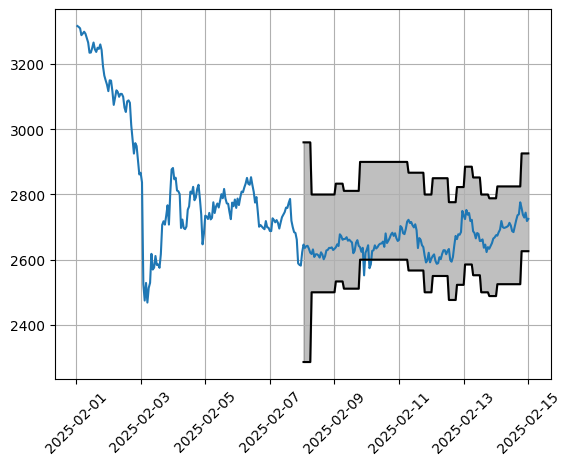

In [16]:
B = 100000

evaluation_df, pnl_decomp, total_pnl = evaluate(decision_df,B)

print(pnl_decomp)
print(36.5*100*total_pnl/B)

# evaluation_df[['price_ratio','price_lower','price_upper','fee_usd','myLiquidity','liquidity','myMintsUSD','myBurnsUSD','myFeeRatesUSD','myGasCostsUSD']][100:150]

plt.plot(decision_df.hour,decision_df.price_ratio,color='C0')
plt.plot(decision_df.hour,decision_df.price_lower,color='k')
plt.plot(decision_df.hour,decision_df.price_upper,color='k')
plt.fill_between(decision_df.hour,decision_df.price_lower,decision_df.price_upper,color='k',alpha=0.25)
plt.xticks(rotation=45)
plt.grid()
plt.show()

myMintsUSD       400071.245868
myBurnsUSD       400042.434719
myFeeRatesUSD       828.606867
myGasCostsUSD        45.501101
dtype: float64
27.53175354234485
myMintsUSD       300084.346292
myBurnsUSD       299930.616310
myFeeRatesUSD       589.306688
myGasCostsUSD        29.950902
dtype: float64
14.805341861291172
myMintsUSD       100000.000000
myBurnsUSD       100665.189893
myFeeRatesUSD       343.387427
myGasCostsUSD         5.725979
dtype: float64
36.604073922084545
myMintsUSD       100000.000000
myBurnsUSD       101339.120358
myFeeRatesUSD       187.601548
myGasCostsUSD         5.725979
dtype: float64
55.516351317059396


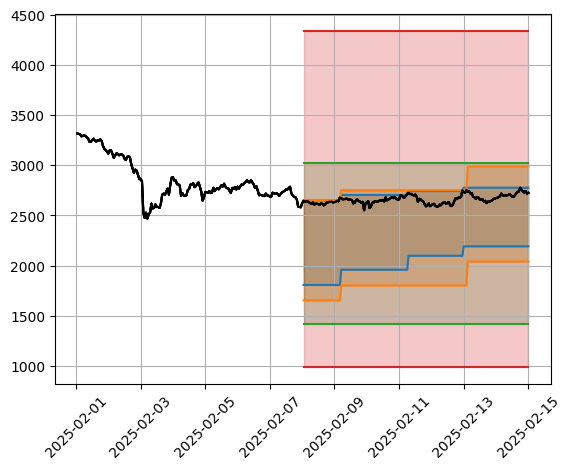

In [24]:
alpha_grid = [0.5,0.75,0.95,0.9999]
color_grid = ['C0','C1','C2','C3']
T = 168

for c in range(len(alpha_grid)):

    concentrated_df = decision_df.copy()

    position_created = 0
    for i in range(len(decision_df)):

        curr_row = concentrated_df.iloc[i]

        if np.isnan(curr_row.price_lower) == 0:
            position_created = 1

        if position_created:

            curr_row = concentrated_df.iloc[i]
            prev_row = concentrated_df.iloc[i-1]

            if np.isnan(prev_row.price_lower) == 1:
                lower, upper = ConfidenceIntervalGBM(concentrated_df.price_ratio.iloc[:i],prev_row.price_ratio,alpha_grid[c],T)
                concentrated_df.loc[i,'price_lower'] = 0.99*min(lower,prev_row.price_ratio)
                concentrated_df.loc[i,'price_upper'] = 1.01*max(upper,prev_row.price_ratio)
            else:
                if (prev_row.price_ratio < prev_row.price_lower) or (prev_row.price_ratio > prev_row.price_upper):
                    lower, upper = ConfidenceIntervalGBM(concentrated_df.price_ratio.iloc[:i],prev_row.price_ratio,alpha_grid[c],T)
                    concentrated_df.loc[i,'price_lower'] = 0.99*min(lower,prev_row.price_ratio)
                    concentrated_df.loc[i,'price_upper'] = 1.01*max(upper,prev_row.price_ratio)
                else:
                    concentrated_df.loc[i,'price_lower'] = concentrated_df.price_lower.iloc[i-1]
                    concentrated_df.loc[i,'price_upper'] = concentrated_df.price_upper.iloc[i-1]
            
    evaluation_df, pnl_decomp, total_pnl = evaluate(concentrated_df,B)

    print(pnl_decomp)
    print(36.5*100*total_pnl/B)

    plt.plot(concentrated_df.hour,concentrated_df.price_ratio,color='k')
    plt.plot(concentrated_df.hour,concentrated_df.price_lower,color=color_grid[c])
    plt.plot(concentrated_df.hour,concentrated_df.price_upper,color=color_grid[c])
    plt.fill_between(concentrated_df.hour,concentrated_df.price_lower,concentrated_df.price_upper,color=color_grid[c],alpha=0.25)
    plt.xticks(rotation=45)

plt.grid()
plt.show()

In [20]:
fullrange_df = decision_df.copy()
fullrange_df.price_lower = fullrange_df.price_lower.where(fullrange_df.price_lower.isna(),1e-10)
fullrange_df.price_upper = fullrange_df.price_upper.where(fullrange_df.price_upper.isna(),1e10)
fullrange_df

evaluation_df, pnl_decomp, total_pnl = evaluate(fullrange_df,B)

print(pnl_decomp)
print(36.5*100*total_pnl/B)

myMintsUSD       100000.000000
myBurnsUSD       101903.195131
myFeeRatesUSD        57.108424
myGasCostsUSD         5.725979
dtype: float64
71.34208150545447


# Save stuff

In [ ]:
# hours = source_data[0].Hour[167:][::6]
# N_decisions = len(hours)

# rebalance = []
# price_lower = []
# price_upper = []
# rationale = []

# for i in range(N_decisions):
#     if i == 0:
#         rebalance.append(True)
#         price_lower.append(mint_decision[0].lower)
#         price_upper.append(mint_decision[0].upper)
#         rationale.append(mint_decision[0].rationale)
#     else:
#         rebalance.append(rebalance_decisions[i-1][0].rebalance)
#         price_lower.append(rebalance_decisions[i-1][0].new_lower)
#         price_upper.append(rebalance_decisions[i-1][0].new_upper)
#         rationale.append(rebalance_decisions[i-1][0].rationale)

# llm_output_df = pd.DataFrame({
#     'hour': hours,
#     'rebalance': rebalance,
#     'price_lower': price_lower,
#     'price_upper': price_upper,
#     'rationale': rationale
# })

# llm_output_df.to_csv('llm_ouput.csv',index=False)
# llm_output_df

,hour,rebalance,price_lower,price_upper,rationale
0,2025-02-08 00:00:00+00:00,True,2286.000000,2960.000000,The price range is set based on the average ho...
1,2025-02-08 06:00:00+00:00,True,2500.000000,2800.000000,"The price has fluctuated considerably, and rec..."
2,2025-02-08 12:00:00+00:00,False,2500.000000,2800.000000,Maintaining current liquidity position as the ...
3,2025-02-08 18:00:00+00:00,False,2500.000000,2800.000000,Current price is within range. Holding current...
4,2025-02-09 00:00:00+00:00,True,2533.290000,2833.290000,The current price is near the upper bound of t...
5,2025-02-09 06:00:00+00:00,True,2511.114248,2811.114248,The price has moved significantly from the cen...
6,2025-02-09 12:00:00+00:00,False,2511.114248,2811.114248,The current price is within the existing liqui...
7,2025-02-09 18:00:00+00:00,True,2600.000000,2900.000000,"The price has been fluctuating, but trending u..."
8,2025-02-10 00:00:00+00:00,False,2600.000000,2900.000000,The current price is within the range. Keeping...
9,2025-02-10 06:00:00+00:00,False,2600.000000,2900.000000,The current price is within the range of the c...
